# EmotiFusion: A Deep Learning Model for Emotion Detection from Faces and Text

### Setup and Library Installations


In [22]:
!pip install opencv-python glob2 torch torchvision matplotlib seaborn albumentations tqdm numpy


^C



[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
pip install torch


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
!pip install transformers
from transformers import BertTokenizer, BertModel


                                              0.0/12.0 MB ? eta -:--:--
                                              0.0/12.0 MB 1.3 MB/s eta 0:00:10
                                              0.1/12.0 MB 1.3 MB/s eta 0:00:10
                                              0.2/12.0 MB 1.1 MB/s eta 0:00:11
                                              0.2/12.0 MB 1.4 MB/s eta 0:00:09
                                              0.2/12.0 MB 1.4 MB/s eta 0:00:09
                                             0.3/12.0 MB 923.9 kB/s eta 0:00:13
     -                                        0.4/12.0 MB 1.2 MB/s eta 0:00:10
     -                                        0.6/12.0 MB 1.5 MB/s eta 0:00:08
     --                                       0.7/12.0 MB 1.7 MB/s eta 0:00:07
     --                                       0.8/12.0 MB 1.9 MB/s eta 0:00:07
     ---                                      1.0/12.0 MB 1.9 MB/s eta 0:00:06
     ---                                      1.1/12.0 MB 


[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
c:\Users\saita\OneDrive\Desktop\VIT\7th sem\DL\PROJECT\Emotion-detection\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
!pip uninstall torch -y
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Found existing installation: torch 2.9.0
Uninstalling torch-2.9.0:
  Successfully uninstalled torch-2.9.0


ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\saita\OneDrive\Desktop\VIT\7th sem\DL\PROJECT\Emotion-detection\venv\Lib\site-packages\pip\_internal\cli\base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "C:\Users\saita\OneDrive\Desktop\VIT\7th sem\DL\PROJECT\Emotion-detection\venv\Lib\site-packages\pip\_internal\commands\uninstall.py", line 110, in run
    uninstall_pathset.commit()
  File "C:\Users\saita\OneDrive\Desktop\VIT\7th sem\DL\PROJECT\Emotion-detection\venv\Lib\site-packages\pip\_internal\req\req_uninstall.py", line 432, in commit
    self._moved_paths.commit()
  File "C:\Users\saita\OneDrive\Desktop\VIT\7th sem\DL\PROJECT\Emotion-detection\venv\Lib\site-packages\pip\_internal\req\req_uninstall.py", line 278, in commit
    save_dir.cleanup()
  File "C:\Users\saita\OneDrive\Desktop\VIT\7th sem\DL\PROJECT\Emotion-detection\venv\Lib\site-packages\pip\_internal\utils\temp_dir.py", line 173, in

In [ ]:
pip install openpyxl


  Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### Import Required Libraries


In [ ]:
import os
import cv2
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import numpy as np


### Load and Prepare Dataset


In [ ]:
# from google.colab import files
# uploaded = files.upload()

import zipfile
import os
# zip_name = list(uploaded.keys())[0]
# extract_path = "C:/Users/argup/Downloads/archive (2).zip"
# os.makedirs(extract_path, exist_ok=True)
# with zipfile.ZipFile(zip_name, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

DATASET_PATH = "./src/YOLO_format"
print("📁 Dataset contents:", os.listdir("./src/YOLO_format"))

import yaml
yaml_path = os.path.join(DATASET_PATH, "data.yaml")
if not os.path.exists(yaml_path):
    raise FileNotFoundError(f" data.yaml not found at {yaml_path}")

with open(yaml_path, "r") as f:
    data_cfg = yaml.safe_load(f)

CLASSES = data_cfg["names"]
print("✅ Classes:", CLASSES)

IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = len(CLASSES)
print(f"📊 Total classes: {NUM_CLASSES}")



📁 Dataset contents: ['data.yaml', 'test', 'train', 'valid']
✅ Classes: ['Anger', 'Contempt', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
📊 Total classes: 8


### Check GPU / CPU Availability


In [ ]:
    import torch
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
        device = torch.device("cuda")
    else:
        print("No GPU available. Training will run on CPU.")
        device = torch.device("cpu")
    print(f"Device: {device}")

No GPU available. Training will run on CPU.
Device: cpu


### Define Emotion Labels and Dialogue Templates


In [ ]:
import random
import pandas as pd

# ============================================================
#  AffectNet Emotion Mapping
# ============================================================

emotion_map = {
    0: "Anger",
    1: "Contempt",
    2: "Disgust",
    3: "Fear",
    4: "Happy",
    5: "Neutral",
    6: "Sad",
    7: "Surprise"
}

# ============================================================
#  Dialogue Templates Per Emotion (Base Pools)
#  You can extend these or keep as-is.
#  The script will RANDOMIZE and create 30 variations per emotion.
# ============================================================

base_dialogues = {
    "Anger": [
        "I can't deal with this right now!",
        "Why does this always happen to me?",
        "I'm seriously getting irritated.",
        "This is absolutely unacceptable!",
        "Don't test my patience today.",
        "I'm so done with this nonsense.",
        "Stop messing around and focus!",
        "I can't believe this is happening!",
        "I'm getting tired of repeating myself.",
        "This is making me really angry."
    ],
    "Contempt": [
        "Oh please, that's laughable.",
        "I can't believe you're serious.",
        "Is this really the best you can do?",
        "I expected more, honestly.",
        "That's just pathetic.",
        "Wow… embarrassing.",
        "I don't even have words for this.",
        "You can't be serious right now.",
        "Try harder next time.",
        "This is beneath me."
    ],
    "Disgust": [
        "Ugh, that's disgusting.",
        "I can't even look at that.",
        "This is revolting.",
        "Get that away from me!",
        "Gross… absolutely gross.",
        "I feel nauseous just seeing this.",
        "Why would anyone touch that?",
        "Ew! That’s horrible.",
        "I don’t like this at all.",
        "Please stop showing me this."
    ],
    "Fear": [
        "I feel really scared right now.",
        "What was that noise?",
        "I don't think we're safe here.",
        "Something feels off.",
        "Can we leave? I'm nervous.",
        "I'm not comfortable with this.",
        "This place creeps me out.",
        "Did you see that?",
        "I'm shaking… I’m so scared.",
        "I have a really bad feeling."
    ],
    "Happy": [
        "This is amazing!",
        "I'm so happy today!",
        "Everything feels perfect.",
        "I can't stop smiling!",
        "What a beautiful moment.",
        "This made my whole day.",
        "I'm feeling so joyful.",
        "I love this so much!",
        "Life is really good right now.",
        "I’m genuinely happy."
    ],
    "Neutral": [
        "Alright, that makes sense.",
        "Okay. I'm listening.",
        "Noted. Continue.",
        "I understand.",
        "Sure, that works.",
        "That's fine with me.",
        "Alright.",
        "Okay.",
        "Proceed.",
        "As you wish."
    ],
    "Sad": [
        "I feel really low today.",
        "Nothing seems to help right now.",
        "I just want to be alone.",
        "Everything feels heavy.",
        "I wish things were different.",
        "I'm trying, but it’s hard.",
        "I don’t feel good emotionally.",
        "It hurts more than I expected.",
        "I'm barely holding on.",
        "I just want this pain to stop."
    ],
    "Surprise": [
        "Whoa! What just happened?",
        "I did NOT expect that!",
        "Oh my god, seriously?",
        "That was shocking!",
        "Wait—what??",
        "This is unbelievable!",
        "I did not see that coming.",
        "Hold on… what???",
        "That surprised me a lot.",
        "Wow! That’s unexpected."
    ]
}

# ============================================================
#  Function: Generate 30 Randomized Dialogues Per Emotion
# ============================================================

def generate_dialogues():
    rows = []

    for emotion_id, emotion_label in emotion_map.items():
        base = base_dialogues[emotion_label]

        for i in range(30):
            # Random base + random slight variation
            text = random.choice(base)

            # Add randomized suffix to make variations unique
            variant = random.choice([
                "", 
                " Honestly.", 
                " Seriously.", 
                " I'm not kidding.", 
                " You know?", 
                " Just saying.", 
                " I mean it.",
                " Really."
            ])

            final_dialogue = f"{text}{variant}"

            rows.append([emotion_id, emotion_label, final_dialogue])

    return pd.DataFrame(rows, columns=["emotion_id", "emotion_label", "synthetic_dialogue"])

# ============================================================
#  Generate and Save
# ============================================================

df = generate_dialogues()
df.to_excel("synthetic_emotion_dialogues.xlsx", index=False)
df.to_csv("synthetic_emotion_dialogues.csv", index=False)

print("✅ Generated 30 synthetic dialogues per emotion (240 total).")
print("✅ Saved as synthetic_emotion_dialogues.xlsx and .csv")


✅ Generated 30 synthetic dialogues per emotion (240 total).
✅ Saved as synthetic_emotion_dialogues.xlsx and .csv


### Tokenize and Prepare Text Data (BERT)


In [37]:

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class DialogueDataset(Dataset):
    def __init__(self, df, max_len=32):
        self.df = df
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row["synthetic_dialogue"]
        label = row["emotion_id"]

        enc = tokenizer.encode_plus(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        return enc["input_ids"].squeeze(0), enc["attention_mask"].squeeze(0), torch.tensor(label)



### Prepare Image Dataset (AffectNet)


In [36]:
class AffectNetDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.images = sorted(glob.glob(os.path.join(img_dir, "*.jpg")) + 
                             glob.glob(os.path.join(img_dir, "*.png")))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label_path = os.path.join(
            self.label_dir, 
            os.path.basename(img_path).replace(".png", ".txt").replace(".jpg", ".txt")
        )

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # read YOLO label
        with open(label_path) as f:
            line = f.readline().strip().split()
            class_id = int(line[0])

        if self.transform:
            img = self.transform(image=img)["image"]

        return img, class_id


### Apply Data Augmentation and Transformations


In [38]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_tfms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.Rotate(limit=15),
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])

val_tfms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])


### Create DataLoaders for Training and Validation


In [40]:
dialogue_df = pd.read_csv("synthetic_emotion_dialogues.csv")

DATASET_PATH = r"C:\Users\saita\OneDrive\Desktop\VIT\7th sem\DL\PROJECT\Emotion-detection\src\YOLO_format"

train_ds = AffectNetDataset(
    os.path.join(DATASET_PATH, "train/images"),
    os.path.join(DATASET_PATH, "train/labels"),
    transform=train_tfms
)

val_ds = AffectNetDataset(
    os.path.join(DATASET_PATH, "valid/images"),
    os.path.join(DATASET_PATH, "valid/labels"),
    transform=val_tfms
)

text_ds = DialogueDataset(dialogue_df)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE)
text_dl  = DataLoader(text_ds, batch_size=BATCH_SIZE, shuffle=True)

print("Train Images:", len(train_ds))
print("Train Texts:", len(text_ds))


Train Images: 17101
Train Texts: 240


### Define Attention Mechanisms (Channel & Spatial)


In [41]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=8):
        super().__init__()
        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1)
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1)

    def forward(self, x):
        avg_out = torch.mean(x, dim=(2,3), keepdim=True)
        out = torch.relu(self.fc1(avg_out))
        out = torch.sigmoid(self.fc2(out))
        return x * out

class SpatialAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size=7, padding=3)

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        att = torch.sigmoid(self.conv1(x_cat))
        return x * att

class FERCNet(nn.Module):
    def __init__(self, num_classes=8, out_dim=512):
        super().__init__()
        resnet = models.resnet18(weights="IMAGENET1K_V1")
        mobilenet = models.mobilenet_v3_small(weights="IMAGENET1K_V1")

        self.res_feat = nn.Sequential(*list(resnet.children())[:-2])
        self.mob_feat = mobilenet.features

        self.channel_att = ChannelAttention(512 + 576)
        self.spatial_att = SpatialAttention()

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(1088, out_dim)

    def forward(self, x):
        f1 = self.res_feat(x)
        f2 = self.mob_feat(x)
        f_cat = torch.cat([f1, f2], dim=1)

        f_att = self.channel_att(self.spatial_att(f_cat))
        f_vec = self.avgpool(f_att).flatten(1)
        return self.fc(f_vec)


### Define Text Encoder (BERT-based)


In [42]:
class TextEncoder(nn.Module):
    def __init__(self, out_dim=512):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.fc = nn.Linear(768, out_dim)

    def forward(self, ids, mask):
        outputs = self.bert(input_ids=ids, attention_mask=mask)
        cls = outputs.last_hidden_state[:,0,:]
        return self.fc(cls)


### Define Fusion Network for Multimodal Emotion Classification


In [43]:
class FusionClassifier(nn.Module):
    def __init__(self, hidden=512, num_classes=8):
        super().__init__()
        self.fc1 = nn.Linear(hidden*2, 512)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, img_feat, txt_feat):
        fused = torch.cat([img_feat, txt_feat], dim=1)
        x = torch.relu(self.fc1(fused))
        x = self.dropout(x)
        return self.fc2(x)


In [44]:
device = "cuda" if torch.cuda.is_available() else "cpu"

img_encoder = FERCNet().to(device)
txt_encoder = TextEncoder().to(device)
fusion = FusionClassifier().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    list(img_encoder.parameters()) +
    list(txt_encoder.parameters()) +
    list(fusion.parameters()),
    lr=1e-4
)


In [46]:
from itertools import cycle


In [49]:
from torch.utils.data import Dataset
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class DialogueDataset(Dataset):
    def __init__(self, df, max_len=32):
        self.df = df
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text  = row["synthetic_dialogue"]
        label = int(row["emotion_id"])

        enc = tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        input_ids      = enc["input_ids"].squeeze(0)
        attention_mask = enc["attention_mask"].squeeze(0)

        return input_ids, attention_mask, label


In [50]:
dialogue_df = pd.read_csv("synthetic_emotion_dialogues.csv")

text_ds = DialogueDataset(dialogue_df)
text_dl = DataLoader(text_ds, batch_size=BATCH_SIZE, shuffle=True)


In [56]:
from tqdm import tqdm
import torch

img_encoder.train()
txt_encoder.train()
fusion.train()

correct = 0
total = 0
total_loss = 0

for imgs, img_labels in tqdm(train_dl, desc="Training", total=len(train_dl)):
    txt_ids, txt_mask, txt_labels = next(text_iter)

    imgs, img_labels = imgs.to(device), img_labels.to(device)
    txt_ids, txt_mask, txt_labels = txt_ids.to(device), txt_mask.to(device), txt_labels.to(device)

    optimizer.zero_grad()

    # Forward pass
    img_feat = img_encoder(imgs)
    txt_feat = txt_encoder(txt_ids, txt_mask)
    preds = fusion(img_feat, txt_feat)

    # Compute loss
    loss = criterion(preds, img_labels)
    loss.backward()
    optimizer.step()

    # Track loss
    total_loss += loss.item()

    # ✅ Compute accuracy
    with torch.no_grad():
        predicted = torch.argmax(preds, dim=1)
        correct += (predicted == img_labels).sum().item()
        total += img_labels.size(0)

    # ✅ Print live metrics
    acc = 100 * correct / total
    avg_loss = total_loss / total if total > 0 else 0
    tqdm.write(f"Loss: {loss.item():.4f} | Running Acc: {acc:.2f}%")

# ✅ Epoch summary after loop
epoch_acc = 100 * correct / total
epoch_loss = total_loss / len(train_dl)
print(f"\nEpoch Summary — Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.2f}%")


Training:   0%|          | 1/534 [00:09<1:22:47,  9.32s/it]

Loss: 0.9536 | Running Acc: 65.62%


Training:   0%|          | 2/534 [00:20<1:30:02, 10.16s/it]

Loss: 0.7858 | Running Acc: 68.75%


Training:   1%|          | 3/534 [00:33<1:43:01, 11.64s/it]

Loss: 0.7736 | Running Acc: 70.83%


Training:   1%|          | 4/534 [00:44<1:39:36, 11.28s/it]

Loss: 0.8440 | Running Acc: 69.53%


Training:   1%|          | 5/534 [00:52<1:29:52, 10.19s/it]

Loss: 0.7010 | Running Acc: 72.50%


Training:   1%|          | 6/534 [01:01<1:26:52,  9.87s/it]

Loss: 0.7075 | Running Acc: 73.44%


Training:   1%|▏         | 7/534 [01:10<1:22:19,  9.37s/it]

Loss: 1.0432 | Running Acc: 71.43%


Training:   1%|▏         | 8/534 [01:18<1:18:16,  8.93s/it]

Loss: 1.0380 | Running Acc: 70.70%


Training:   2%|▏         | 9/534 [01:26<1:17:15,  8.83s/it]

Loss: 1.0696 | Running Acc: 68.75%


Training:   2%|▏         | 10/534 [01:34<1:15:48,  8.68s/it]

Loss: 0.8785 | Running Acc: 68.75%


Training:   2%|▏         | 11/534 [01:42<1:13:13,  8.40s/it]

Loss: 0.9576 | Running Acc: 67.61%


Training:   2%|▏         | 12/534 [01:51<1:13:41,  8.47s/it]

Loss: 0.9409 | Running Acc: 67.45%


Training:   2%|▏         | 13/534 [01:59<1:13:18,  8.44s/it]

Loss: 0.6689 | Running Acc: 68.27%


Training:   3%|▎         | 14/534 [02:08<1:14:32,  8.60s/it]

Loss: 1.0727 | Running Acc: 68.08%


Training:   3%|▎         | 15/534 [02:16<1:13:10,  8.46s/it]

Loss: 1.0112 | Running Acc: 67.50%


Training:   3%|▎         | 16/534 [02:25<1:13:48,  8.55s/it]

Loss: 1.3861 | Running Acc: 66.60%


Training:   3%|▎         | 17/534 [02:34<1:14:34,  8.66s/it]

Loss: 1.1008 | Running Acc: 66.36%


Training:   3%|▎         | 18/534 [02:42<1:11:54,  8.36s/it]

Loss: 0.6108 | Running Acc: 67.53%


Training:   4%|▎         | 19/534 [02:50<1:12:18,  8.42s/it]

Loss: 0.8296 | Running Acc: 67.60%


Training:   4%|▎         | 20/534 [02:58<1:11:30,  8.35s/it]

Loss: 1.2372 | Running Acc: 66.56%


Training:   4%|▍         | 21/534 [03:07<1:11:08,  8.32s/it]

Loss: 1.1934 | Running Acc: 65.92%


Training:   4%|▍         | 22/534 [03:15<1:11:10,  8.34s/it]

Loss: 0.9966 | Running Acc: 65.77%


Training:   4%|▍         | 23/534 [03:24<1:13:00,  8.57s/it]

Loss: 0.7476 | Running Acc: 66.17%


Training:   4%|▍         | 24/534 [03:32<1:10:30,  8.30s/it]

Loss: 0.6582 | Running Acc: 66.54%


Training:   5%|▍         | 25/534 [03:41<1:11:18,  8.41s/it]

Loss: 1.1702 | Running Acc: 65.75%


Training:   5%|▍         | 26/534 [03:49<1:11:05,  8.40s/it]

Loss: 0.8123 | Running Acc: 65.87%


Training:   5%|▌         | 27/534 [03:57<1:10:41,  8.37s/it]

Loss: 1.0806 | Running Acc: 65.74%


Training:   5%|▌         | 28/534 [04:05<1:10:26,  8.35s/it]

Loss: 1.0410 | Running Acc: 65.62%


Training:   5%|▌         | 29/534 [04:14<1:10:09,  8.34s/it]

Loss: 0.8579 | Running Acc: 65.62%


Training:   6%|▌         | 30/534 [04:22<1:10:06,  8.35s/it]

Loss: 0.9707 | Running Acc: 65.83%


Training:   6%|▌         | 31/534 [04:31<1:10:03,  8.36s/it]

Loss: 0.6004 | Running Acc: 66.33%


Training:   6%|▌         | 32/534 [04:38<1:07:18,  8.04s/it]

Loss: 0.8337 | Running Acc: 66.50%


Training:   6%|▌         | 33/534 [04:47<1:09:10,  8.29s/it]

Loss: 0.7452 | Running Acc: 66.76%


Training:   6%|▋         | 34/534 [04:56<1:12:03,  8.65s/it]

Loss: 1.2131 | Running Acc: 66.64%


Training:   7%|▋         | 35/534 [05:05<1:13:12,  8.80s/it]

Loss: 0.7197 | Running Acc: 66.96%


Training:   7%|▋         | 36/534 [05:14<1:12:01,  8.68s/it]

Loss: 1.1856 | Running Acc: 66.93%


Training:   7%|▋         | 37/534 [05:22<1:11:24,  8.62s/it]

Loss: 0.9451 | Running Acc: 66.89%


Training:   7%|▋         | 38/534 [05:30<1:09:35,  8.42s/it]

Loss: 0.9630 | Running Acc: 66.78%


Training:   7%|▋         | 39/534 [05:39<1:11:02,  8.61s/it]

Loss: 0.9779 | Running Acc: 66.75%


Training:   7%|▋         | 40/534 [05:48<1:11:46,  8.72s/it]

Loss: 0.8798 | Running Acc: 66.48%


Training:   8%|▊         | 41/534 [05:57<1:11:56,  8.75s/it]

Loss: 0.9601 | Running Acc: 66.46%


Training:   8%|▊         | 42/534 [06:06<1:13:14,  8.93s/it]

Loss: 0.8779 | Running Acc: 66.52%


Training:   8%|▊         | 43/534 [06:16<1:13:38,  9.00s/it]

Loss: 0.9751 | Running Acc: 66.72%


Training:   8%|▊         | 44/534 [06:25<1:13:50,  9.04s/it]

Loss: 1.1718 | Running Acc: 66.48%


Training:   8%|▊         | 45/534 [06:34<1:14:38,  9.16s/it]

Loss: 1.1864 | Running Acc: 66.39%


Training:   9%|▊         | 46/534 [06:43<1:14:16,  9.13s/it]

Loss: 1.1379 | Running Acc: 66.17%


Training:   9%|▉         | 47/534 [06:53<1:14:35,  9.19s/it]

Loss: 0.6706 | Running Acc: 66.42%


Training:   9%|▉         | 48/534 [07:01<1:12:21,  8.93s/it]

Loss: 0.8526 | Running Acc: 66.34%


Training:   9%|▉         | 49/534 [07:09<1:11:17,  8.82s/it]

Loss: 0.7188 | Running Acc: 66.52%


Training:   9%|▉         | 50/534 [07:18<1:10:11,  8.70s/it]

Loss: 0.9709 | Running Acc: 66.62%


Training:  10%|▉         | 51/534 [07:26<1:09:03,  8.58s/it]

Loss: 0.9824 | Running Acc: 66.61%


Training:  10%|▉         | 52/534 [07:35<1:09:43,  8.68s/it]

Loss: 0.8172 | Running Acc: 66.71%


Training:  10%|▉         | 53/534 [07:44<1:10:40,  8.82s/it]

Loss: 0.9472 | Running Acc: 66.57%


Training:  10%|█         | 54/534 [07:54<1:12:08,  9.02s/it]

Loss: 0.8499 | Running Acc: 66.72%


Training:  10%|█         | 55/534 [08:03<1:13:10,  9.17s/it]

Loss: 1.0569 | Running Acc: 66.53%


Training:  10%|█         | 56/534 [08:13<1:14:00,  9.29s/it]

Loss: 0.8458 | Running Acc: 66.52%


Training:  11%|█         | 57/534 [08:22<1:13:46,  9.28s/it]

Loss: 0.8790 | Running Acc: 66.39%


Training:  11%|█         | 58/534 [08:31<1:13:15,  9.23s/it]

Loss: 0.8148 | Running Acc: 66.54%


Training:  11%|█         | 59/534 [08:39<1:09:58,  8.84s/it]

Loss: 1.0129 | Running Acc: 66.42%


Training:  11%|█         | 60/534 [08:49<1:11:28,  9.05s/it]

Loss: 0.6133 | Running Acc: 66.56%


Training:  11%|█▏        | 61/534 [08:59<1:13:24,  9.31s/it]

Loss: 1.0980 | Running Acc: 66.60%


Training:  12%|█▏        | 62/534 [09:08<1:12:50,  9.26s/it]

Loss: 0.8919 | Running Acc: 66.48%


Training:  12%|█▏        | 63/534 [09:16<1:10:20,  8.96s/it]

Loss: 1.0956 | Running Acc: 66.22%


Training:  12%|█▏        | 64/534 [09:23<1:06:32,  8.50s/it]

Loss: 1.1958 | Running Acc: 65.87%


Training:  12%|█▏        | 65/534 [09:32<1:07:10,  8.59s/it]

Loss: 0.9314 | Running Acc: 65.82%


Training:  12%|█▏        | 66/534 [09:41<1:07:07,  8.60s/it]

Loss: 0.8904 | Running Acc: 65.86%


Training:  13%|█▎        | 67/534 [09:49<1:06:06,  8.49s/it]

Loss: 0.8611 | Running Acc: 65.81%


Training:  13%|█▎        | 68/534 [09:58<1:06:41,  8.59s/it]

Loss: 1.1780 | Running Acc: 65.67%


Training:  13%|█▎        | 69/534 [10:06<1:06:34,  8.59s/it]

Loss: 0.9538 | Running Acc: 65.62%


Training:  13%|█▎        | 70/534 [10:15<1:05:50,  8.51s/it]

Loss: 0.7537 | Running Acc: 65.67%


Training:  13%|█▎        | 71/534 [10:24<1:06:32,  8.62s/it]

Loss: 1.1979 | Running Acc: 65.58%


Training:  13%|█▎        | 72/534 [10:33<1:08:32,  8.90s/it]

Loss: 1.1012 | Running Acc: 65.36%


Training:  14%|█▎        | 73/534 [10:42<1:09:17,  9.02s/it]

Loss: 0.7738 | Running Acc: 65.45%


Training:  14%|█▍        | 74/534 [10:51<1:06:55,  8.73s/it]

Loss: 0.8293 | Running Acc: 65.54%


Training:  14%|█▍        | 75/534 [10:59<1:06:41,  8.72s/it]

Loss: 0.8905 | Running Acc: 65.54%


Training:  14%|█▍        | 76/534 [11:08<1:07:17,  8.82s/it]

Loss: 0.6035 | Running Acc: 65.71%


Training:  14%|█▍        | 77/534 [11:17<1:07:09,  8.82s/it]

Loss: 0.8573 | Running Acc: 65.75%


Training:  15%|█▍        | 78/534 [11:26<1:06:45,  8.78s/it]

Loss: 0.7621 | Running Acc: 65.75%


Training:  15%|█▍        | 79/534 [11:35<1:07:21,  8.88s/it]

Loss: 0.9698 | Running Acc: 65.70%


Training:  15%|█▍        | 80/534 [11:45<1:09:33,  9.19s/it]

Loss: 0.7568 | Running Acc: 65.86%


Training:  15%|█▌        | 81/534 [11:53<1:06:51,  8.86s/it]

Loss: 0.7279 | Running Acc: 66.05%


Training:  15%|█▌        | 82/534 [12:03<1:08:42,  9.12s/it]

Loss: 0.8433 | Running Acc: 66.01%


Training:  16%|█▌        | 83/534 [12:12<1:08:03,  9.06s/it]

Loss: 1.0446 | Running Acc: 65.81%


Training:  16%|█▌        | 84/534 [12:20<1:07:23,  8.98s/it]

Loss: 0.8221 | Running Acc: 65.77%


Training:  16%|█▌        | 85/534 [12:30<1:08:13,  9.12s/it]

Loss: 0.8778 | Running Acc: 65.88%


Training:  16%|█▌        | 86/534 [12:39<1:09:01,  9.24s/it]

Loss: 0.6452 | Running Acc: 66.06%


Training:  16%|█▋        | 87/534 [12:48<1:08:28,  9.19s/it]

Loss: 1.1015 | Running Acc: 65.98%


Training:  16%|█▋        | 88/534 [12:57<1:07:02,  9.02s/it]

Loss: 1.2152 | Running Acc: 65.87%


Training:  17%|█▋        | 89/534 [13:07<1:08:11,  9.19s/it]

Loss: 0.7828 | Running Acc: 66.01%


Training:  17%|█▋        | 90/534 [13:16<1:07:47,  9.16s/it]

Loss: 0.7431 | Running Acc: 66.04%


Training:  17%|█▋        | 91/534 [13:25<1:06:55,  9.06s/it]

Loss: 0.5946 | Running Acc: 66.24%


Training:  17%|█▋        | 92/534 [13:34<1:07:22,  9.15s/it]

Loss: 0.9863 | Running Acc: 66.13%


Training:  17%|█▋        | 93/534 [13:43<1:06:58,  9.11s/it]

Loss: 0.8710 | Running Acc: 66.16%


Training:  18%|█▊        | 94/534 [13:53<1:07:57,  9.27s/it]

Loss: 1.1216 | Running Acc: 66.02%


Training:  18%|█▊        | 95/534 [14:02<1:08:27,  9.36s/it]

Loss: 0.7871 | Running Acc: 66.05%


Training:  18%|█▊        | 96/534 [14:11<1:07:04,  9.19s/it]

Loss: 1.1377 | Running Acc: 66.05%


Training:  18%|█▊        | 97/534 [14:20<1:05:54,  9.05s/it]

Loss: 0.9661 | Running Acc: 66.04%


Training:  18%|█▊        | 98/534 [14:28<1:04:42,  8.91s/it]

Loss: 1.0095 | Running Acc: 65.91%


Training:  19%|█▊        | 99/534 [14:37<1:04:10,  8.85s/it]

Loss: 1.0118 | Running Acc: 65.88%


Training:  19%|█▊        | 100/534 [14:46<1:04:03,  8.86s/it]

Loss: 1.0618 | Running Acc: 65.84%


Training:  19%|█▉        | 101/534 [14:55<1:04:06,  8.88s/it]

Loss: 0.7291 | Running Acc: 65.87%


Training:  19%|█▉        | 102/534 [15:03<1:03:10,  8.77s/it]

Loss: 0.9586 | Running Acc: 65.90%


Training:  19%|█▉        | 103/534 [15:12<1:02:26,  8.69s/it]

Loss: 0.7562 | Running Acc: 65.93%


Training:  19%|█▉        | 104/534 [15:21<1:03:19,  8.84s/it]

Loss: 0.8817 | Running Acc: 65.96%


Training:  20%|█▉        | 105/534 [15:30<1:03:07,  8.83s/it]

Loss: 1.0068 | Running Acc: 65.95%


Training:  20%|█▉        | 106/534 [15:39<1:03:11,  8.86s/it]

Loss: 0.6164 | Running Acc: 66.10%


Training:  20%|██        | 107/534 [15:47<1:02:35,  8.80s/it]

Loss: 0.6502 | Running Acc: 66.21%


Training:  20%|██        | 108/534 [15:56<1:02:29,  8.80s/it]

Loss: 0.7705 | Running Acc: 66.20%


Training:  20%|██        | 109/534 [16:06<1:03:32,  8.97s/it]

Loss: 1.1435 | Running Acc: 66.20%


Training:  21%|██        | 110/534 [16:15<1:04:06,  9.07s/it]

Loss: 1.1173 | Running Acc: 66.14%


Training:  21%|██        | 111/534 [16:25<1:05:17,  9.26s/it]

Loss: 1.1069 | Running Acc: 66.02%


Training:  21%|██        | 112/534 [16:34<1:05:26,  9.30s/it]

Loss: 0.9691 | Running Acc: 65.96%


Training:  21%|██        | 113/534 [16:43<1:05:25,  9.32s/it]

Loss: 1.0159 | Running Acc: 65.85%


Training:  21%|██▏       | 114/534 [16:53<1:05:41,  9.38s/it]

Loss: 0.8292 | Running Acc: 65.84%


Training:  22%|██▏       | 115/534 [17:03<1:06:35,  9.54s/it]

Loss: 1.1178 | Running Acc: 65.71%


Training:  22%|██▏       | 116/534 [17:11<1:02:48,  9.02s/it]

Loss: 1.0266 | Running Acc: 65.68%


Training:  22%|██▏       | 117/534 [17:24<1:12:02, 10.37s/it]

Loss: 0.8002 | Running Acc: 65.79%


Training:  22%|██▏       | 118/534 [17:32<1:06:30,  9.59s/it]

Loss: 0.7868 | Running Acc: 65.86%


Training:  22%|██▏       | 119/534 [17:44<1:10:43, 10.23s/it]

Loss: 1.1502 | Running Acc: 65.86%


Training:  22%|██▏       | 120/534 [18:01<1:25:15, 12.36s/it]

Loss: 0.6454 | Running Acc: 65.96%


Training:  23%|██▎       | 121/534 [18:15<1:28:21, 12.84s/it]

Loss: 0.8784 | Running Acc: 65.93%


Training:  23%|██▎       | 122/534 [18:29<1:30:22, 13.16s/it]

Loss: 1.0786 | Running Acc: 65.80%


Training:  23%|██▎       | 123/534 [18:43<1:31:55, 13.42s/it]

Loss: 0.9279 | Running Acc: 65.83%


Training:  23%|██▎       | 124/534 [18:55<1:28:30, 12.95s/it]

Loss: 0.8383 | Running Acc: 65.85%


Training:  23%|██▎       | 125/534 [19:02<1:17:35, 11.38s/it]

Loss: 0.8472 | Running Acc: 65.83%


Training:  24%|██▎       | 126/534 [19:10<1:09:30, 10.22s/it]

Loss: 0.8801 | Running Acc: 65.82%


Training:  24%|██▍       | 127/534 [19:18<1:04:18,  9.48s/it]

Loss: 0.8555 | Running Acc: 65.85%


Training:  24%|██▍       | 128/534 [19:25<1:00:27,  8.93s/it]

Loss: 1.0567 | Running Acc: 65.84%


Training:  24%|██▍       | 129/534 [19:33<57:36,  8.53s/it]  

Loss: 0.8687 | Running Acc: 65.87%


Training:  24%|██▍       | 130/534 [19:40<55:17,  8.21s/it]

Loss: 1.1560 | Running Acc: 65.77%


Training:  25%|██▍       | 131/534 [19:48<54:01,  8.04s/it]

Loss: 0.7207 | Running Acc: 65.79%


Training:  25%|██▍       | 132/534 [19:56<52:57,  7.91s/it]

Loss: 1.1568 | Running Acc: 65.72%


Training:  25%|██▍       | 133/534 [20:03<52:12,  7.81s/it]

Loss: 0.8561 | Running Acc: 65.72%


Training:  25%|██▌       | 134/534 [20:11<51:22,  7.71s/it]

Loss: 0.9488 | Running Acc: 65.74%


Training:  25%|██▌       | 135/534 [20:18<50:57,  7.66s/it]

Loss: 1.1139 | Running Acc: 65.69%


Training:  25%|██▌       | 136/534 [20:26<50:44,  7.65s/it]

Loss: 1.0936 | Running Acc: 65.62%


Training:  26%|██▌       | 137/534 [20:33<50:23,  7.62s/it]

Loss: 0.9144 | Running Acc: 65.65%


Training:  26%|██▌       | 138/534 [20:41<50:16,  7.62s/it]

Loss: 1.0952 | Running Acc: 65.53%


Training:  26%|██▌       | 139/534 [20:49<50:07,  7.61s/it]

Loss: 1.0275 | Running Acc: 65.49%


Training:  26%|██▌       | 140/534 [20:56<49:47,  7.58s/it]

Loss: 0.8987 | Running Acc: 65.45%


Training:  26%|██▋       | 141/534 [21:04<49:50,  7.61s/it]

Loss: 1.1118 | Running Acc: 65.43%


Training:  27%|██▋       | 142/534 [21:11<49:25,  7.57s/it]

Loss: 0.9002 | Running Acc: 65.43%


Training:  27%|██▋       | 143/534 [21:19<49:24,  7.58s/it]

Loss: 0.9553 | Running Acc: 65.45%


Training:  27%|██▋       | 144/534 [21:26<49:04,  7.55s/it]

Loss: 0.8817 | Running Acc: 65.49%


Training:  27%|██▋       | 145/534 [21:34<48:46,  7.52s/it]

Loss: 0.7455 | Running Acc: 65.47%


Training:  27%|██▋       | 146/534 [21:41<48:20,  7.48s/it]

Loss: 1.0889 | Running Acc: 65.45%


Training:  28%|██▊       | 147/534 [21:49<48:17,  7.49s/it]

Loss: 0.8514 | Running Acc: 65.48%


Training:  28%|██▊       | 148/534 [21:56<48:13,  7.50s/it]

Loss: 1.5507 | Running Acc: 65.39%


Training:  28%|██▊       | 149/534 [22:04<48:12,  7.51s/it]

Loss: 0.8872 | Running Acc: 65.44%


Training:  28%|██▊       | 150/534 [22:11<48:06,  7.52s/it]

Loss: 1.1628 | Running Acc: 65.40%


Training:  28%|██▊       | 151/534 [22:19<48:09,  7.54s/it]

Loss: 0.8942 | Running Acc: 65.42%


Training:  28%|██▊       | 152/534 [22:26<48:10,  7.57s/it]

Loss: 0.8870 | Running Acc: 65.40%


Training:  29%|██▊       | 153/534 [22:34<47:59,  7.56s/it]

Loss: 1.2206 | Running Acc: 65.28%


Training:  29%|██▉       | 154/534 [22:41<47:47,  7.54s/it]

Loss: 0.7824 | Running Acc: 65.38%


Training:  29%|██▉       | 155/534 [22:49<47:35,  7.53s/it]

Loss: 0.9913 | Running Acc: 65.32%


Training:  29%|██▉       | 156/534 [22:57<48:28,  7.70s/it]

Loss: 1.1405 | Running Acc: 65.30%


Training:  29%|██▉       | 157/534 [23:05<49:24,  7.86s/it]

Loss: 0.8195 | Running Acc: 65.35%


Training:  30%|██▉       | 158/534 [23:16<54:05,  8.63s/it]

Loss: 0.9155 | Running Acc: 65.43%


Training:  30%|██▉       | 159/534 [23:24<52:54,  8.47s/it]

Loss: 0.5641 | Running Acc: 65.55%


Training:  30%|██▉       | 160/534 [23:32<51:41,  8.29s/it]

Loss: 0.8836 | Running Acc: 65.53%


Training:  30%|███       | 161/534 [23:40<51:26,  8.27s/it]

Loss: 1.0942 | Running Acc: 65.49%


Training:  30%|███       | 162/534 [23:48<51:34,  8.32s/it]

Loss: 0.5985 | Running Acc: 65.59%


Training:  31%|███       | 163/534 [23:56<50:45,  8.21s/it]

Loss: 0.8931 | Running Acc: 65.62%


Training:  31%|███       | 164/534 [24:04<49:40,  8.05s/it]

Loss: 0.6998 | Running Acc: 65.70%


Training:  31%|███       | 165/534 [24:12<48:39,  7.91s/it]

Loss: 0.6874 | Running Acc: 65.76%


Training:  31%|███       | 166/534 [24:19<47:48,  7.79s/it]

Loss: 0.8534 | Running Acc: 65.78%


Training:  31%|███▏      | 167/534 [24:27<47:20,  7.74s/it]

Loss: 1.0038 | Running Acc: 65.77%


Training:  31%|███▏      | 168/534 [24:35<47:24,  7.77s/it]

Loss: 0.9762 | Running Acc: 65.72%


Training:  32%|███▏      | 169/534 [24:42<46:54,  7.71s/it]

Loss: 1.1832 | Running Acc: 65.68%


Training:  32%|███▏      | 170/534 [24:50<46:55,  7.74s/it]

Loss: 1.0070 | Running Acc: 65.64%


Training:  32%|███▏      | 171/534 [24:57<46:16,  7.65s/it]

Loss: 0.7768 | Running Acc: 65.68%


Training:  32%|███▏      | 172/534 [25:05<45:49,  7.60s/it]

Loss: 0.9090 | Running Acc: 65.66%


Training:  32%|███▏      | 173/534 [25:12<45:21,  7.54s/it]

Loss: 0.9752 | Running Acc: 65.62%


Training:  33%|███▎      | 174/534 [25:20<44:54,  7.48s/it]

Loss: 0.8105 | Running Acc: 65.59%


Training:  33%|███▎      | 175/534 [25:27<44:42,  7.47s/it]

Loss: 1.0104 | Running Acc: 65.55%


Training:  33%|███▎      | 176/534 [25:34<44:27,  7.45s/it]

Loss: 0.7715 | Running Acc: 65.57%


Training:  33%|███▎      | 177/534 [25:42<44:32,  7.49s/it]

Loss: 1.0448 | Running Acc: 65.52%


Training:  33%|███▎      | 178/534 [25:49<44:01,  7.42s/it]

Loss: 1.2174 | Running Acc: 65.43%


Training:  34%|███▎      | 179/534 [25:57<44:04,  7.45s/it]

Loss: 1.2325 | Running Acc: 65.38%


Training:  34%|███▎      | 180/534 [26:04<44:04,  7.47s/it]

Loss: 0.9568 | Running Acc: 65.36%


Training:  34%|███▍      | 181/534 [26:12<44:01,  7.48s/it]

Loss: 0.7664 | Running Acc: 65.35%


Training:  34%|███▍      | 182/534 [26:19<44:02,  7.51s/it]

Loss: 1.0729 | Running Acc: 65.33%


Training:  34%|███▍      | 183/534 [26:27<43:38,  7.46s/it]

Loss: 0.8604 | Running Acc: 65.32%


Training:  34%|███▍      | 184/534 [26:34<43:47,  7.51s/it]

Loss: 1.1788 | Running Acc: 65.27%


Training:  35%|███▍      | 185/534 [26:42<43:25,  7.46s/it]

Loss: 0.9103 | Running Acc: 65.30%


Training:  35%|███▍      | 186/534 [26:49<43:18,  7.47s/it]

Loss: 0.9259 | Running Acc: 65.32%


Training:  35%|███▌      | 187/534 [26:57<43:06,  7.45s/it]

Loss: 0.9228 | Running Acc: 65.31%


Training:  35%|███▌      | 188/534 [27:04<42:55,  7.44s/it]

Loss: 0.8444 | Running Acc: 65.33%


Training:  35%|███▌      | 189/534 [27:12<42:51,  7.45s/it]

Loss: 0.9745 | Running Acc: 65.29%


Training:  36%|███▌      | 190/534 [27:19<42:39,  7.44s/it]

Loss: 0.7697 | Running Acc: 65.36%


Training:  36%|███▌      | 191/534 [27:27<42:48,  7.49s/it]

Loss: 0.9966 | Running Acc: 65.36%


Training:  36%|███▌      | 192/534 [27:34<42:33,  7.47s/it]

Loss: 1.1410 | Running Acc: 65.33%


Training:  36%|███▌      | 193/534 [27:42<42:41,  7.51s/it]

Loss: 0.9736 | Running Acc: 65.33%


Training:  36%|███▋      | 194/534 [27:49<42:27,  7.49s/it]

Loss: 0.8014 | Running Acc: 65.35%


Training:  37%|███▋      | 195/534 [27:57<42:20,  7.49s/it]

Loss: 0.8717 | Running Acc: 65.35%


Training:  37%|███▋      | 196/534 [28:04<42:18,  7.51s/it]

Loss: 0.7575 | Running Acc: 65.42%


Training:  37%|███▋      | 197/534 [28:12<42:08,  7.50s/it]

Loss: 1.0570 | Running Acc: 65.39%


Training:  37%|███▋      | 198/534 [28:19<41:49,  7.47s/it]

Loss: 0.9585 | Running Acc: 65.37%


Training:  37%|███▋      | 199/534 [28:27<41:59,  7.52s/it]

Loss: 0.9241 | Running Acc: 65.36%


Training:  37%|███▋      | 200/534 [28:34<41:50,  7.52s/it]

Loss: 0.6715 | Running Acc: 65.42%


Training:  38%|███▊      | 201/534 [28:42<41:34,  7.49s/it]

Loss: 1.1169 | Running Acc: 65.38%


Training:  38%|███▊      | 202/534 [28:49<41:31,  7.50s/it]

Loss: 0.8727 | Running Acc: 65.39%


Training:  38%|███▊      | 203/534 [28:57<41:28,  7.52s/it]

Loss: 0.9640 | Running Acc: 65.38%


Training:  38%|███▊      | 204/534 [29:04<41:18,  7.51s/it]

Loss: 0.7754 | Running Acc: 65.41%


Training:  38%|███▊      | 205/534 [29:12<41:27,  7.56s/it]

Loss: 0.9064 | Running Acc: 65.41%


Training:  39%|███▊      | 206/534 [29:19<41:00,  7.50s/it]

Loss: 0.8495 | Running Acc: 65.44%


Training:  39%|███▉      | 207/534 [29:27<40:59,  7.52s/it]

Loss: 1.0321 | Running Acc: 65.40%


Training:  39%|███▉      | 208/534 [29:34<40:58,  7.54s/it]

Loss: 0.8547 | Running Acc: 65.41%


Training:  39%|███▉      | 209/534 [29:42<40:50,  7.54s/it]

Loss: 0.8514 | Running Acc: 65.48%


Training:  39%|███▉      | 210/534 [29:49<40:49,  7.56s/it]

Loss: 0.8163 | Running Acc: 65.49%


Training:  40%|███▉      | 211/534 [29:57<40:34,  7.54s/it]

Loss: 0.9471 | Running Acc: 65.51%


Training:  40%|███▉      | 212/534 [30:05<40:31,  7.55s/it]

Loss: 0.9855 | Running Acc: 65.49%


Training:  40%|███▉      | 213/534 [30:12<40:10,  7.51s/it]

Loss: 0.7226 | Running Acc: 65.51%


Training:  40%|████      | 214/534 [30:19<39:56,  7.49s/it]

Loss: 1.1946 | Running Acc: 65.51%


Training:  40%|████      | 215/534 [30:27<39:45,  7.48s/it]

Loss: 1.0364 | Running Acc: 65.48%


Training:  40%|████      | 216/534 [30:35<40:06,  7.57s/it]

Loss: 1.1428 | Running Acc: 65.38%


Training:  41%|████      | 217/534 [30:42<39:54,  7.55s/it]

Loss: 1.1049 | Running Acc: 65.35%


Training:  41%|████      | 218/534 [30:50<39:41,  7.54s/it]

Loss: 1.0825 | Running Acc: 65.31%


Training:  41%|████      | 219/534 [30:57<39:34,  7.54s/it]

Loss: 0.6856 | Running Acc: 65.38%


Training:  41%|████      | 220/534 [31:05<39:11,  7.49s/it]

Loss: 0.6938 | Running Acc: 65.43%


Training:  41%|████▏     | 221/534 [31:12<39:08,  7.50s/it]

Loss: 0.9607 | Running Acc: 65.40%


Training:  42%|████▏     | 222/534 [31:20<39:07,  7.52s/it]

Loss: 0.9426 | Running Acc: 65.40%


Training:  42%|████▏     | 223/534 [31:27<38:44,  7.47s/it]

Loss: 1.0567 | Running Acc: 65.40%


Training:  42%|████▏     | 224/534 [31:35<38:44,  7.50s/it]

Loss: 0.7397 | Running Acc: 65.44%


Training:  42%|████▏     | 225/534 [31:42<38:51,  7.54s/it]

Loss: 0.8724 | Running Acc: 65.43%


Training:  42%|████▏     | 226/534 [31:50<38:46,  7.55s/it]

Loss: 0.5832 | Running Acc: 65.50%


Training:  43%|████▎     | 227/534 [31:57<38:31,  7.53s/it]

Loss: 1.0896 | Running Acc: 65.46%


Training:  43%|████▎     | 228/534 [32:05<38:34,  7.57s/it]

Loss: 0.8905 | Running Acc: 65.42%


Training:  43%|████▎     | 229/534 [32:12<38:05,  7.49s/it]

Loss: 0.6941 | Running Acc: 65.47%


Training:  43%|████▎     | 230/534 [32:20<37:54,  7.48s/it]

Loss: 0.9297 | Running Acc: 65.49%


Training:  43%|████▎     | 231/534 [32:27<37:38,  7.45s/it]

Loss: 1.2515 | Running Acc: 65.45%


Training:  43%|████▎     | 232/534 [32:35<37:39,  7.48s/it]

Loss: 1.3254 | Running Acc: 65.44%


Training:  44%|████▎     | 233/534 [32:42<37:42,  7.52s/it]

Loss: 0.9607 | Running Acc: 65.42%


Training:  44%|████▍     | 234/534 [32:50<37:33,  7.51s/it]

Loss: 0.7416 | Running Acc: 65.46%


Training:  44%|████▍     | 235/534 [32:57<37:26,  7.51s/it]

Loss: 1.0830 | Running Acc: 65.44%


Training:  44%|████▍     | 236/534 [33:05<37:18,  7.51s/it]

Loss: 0.9354 | Running Acc: 65.43%


Training:  44%|████▍     | 237/534 [33:12<37:12,  7.52s/it]

Loss: 1.2900 | Running Acc: 65.36%


Training:  45%|████▍     | 238/534 [33:20<37:13,  7.54s/it]

Loss: 0.9072 | Running Acc: 65.38%


Training:  45%|████▍     | 239/534 [33:27<37:05,  7.54s/it]

Loss: 1.0237 | Running Acc: 65.39%


Training:  45%|████▍     | 240/534 [33:35<37:02,  7.56s/it]

Loss: 1.1589 | Running Acc: 65.39%


Training:  45%|████▌     | 241/534 [33:43<36:52,  7.55s/it]

Loss: 0.8527 | Running Acc: 65.42%


Training:  45%|████▌     | 242/534 [33:50<36:51,  7.57s/it]

Loss: 0.8294 | Running Acc: 65.42%


Training:  46%|████▌     | 243/534 [33:58<36:41,  7.57s/it]

Loss: 0.7684 | Running Acc: 65.43%


Training:  46%|████▌     | 244/534 [34:05<36:36,  7.57s/it]

Loss: 1.0979 | Running Acc: 65.39%


Training:  46%|████▌     | 245/534 [34:13<36:30,  7.58s/it]

Loss: 0.9393 | Running Acc: 65.41%


Training:  46%|████▌     | 246/534 [34:21<36:27,  7.60s/it]

Loss: 0.9007 | Running Acc: 65.41%


Training:  46%|████▋     | 247/534 [34:28<36:20,  7.60s/it]

Loss: 0.6987 | Running Acc: 65.47%


Training:  46%|████▋     | 248/534 [34:36<36:22,  7.63s/it]

Loss: 1.0127 | Running Acc: 65.47%


Training:  47%|████▋     | 249/534 [34:43<36:07,  7.61s/it]

Loss: 1.0155 | Running Acc: 65.50%


Training:  47%|████▋     | 250/534 [34:51<35:50,  7.57s/it]

Loss: 0.7818 | Running Acc: 65.53%


Training:  47%|████▋     | 251/534 [34:58<35:43,  7.58s/it]

Loss: 0.8290 | Running Acc: 65.51%


Training:  47%|████▋     | 252/534 [35:06<35:29,  7.55s/it]

Loss: 0.8952 | Running Acc: 65.49%


Training:  47%|████▋     | 253/534 [35:14<35:22,  7.55s/it]

Loss: 0.9160 | Running Acc: 65.45%


Training:  48%|████▊     | 254/534 [35:21<35:11,  7.54s/it]

Loss: 0.8029 | Running Acc: 65.49%


Training:  48%|████▊     | 255/534 [35:28<34:40,  7.46s/it]

Loss: 0.8049 | Running Acc: 65.51%


Training:  48%|████▊     | 256/534 [35:36<34:31,  7.45s/it]

Loss: 0.7968 | Running Acc: 65.53%


Training:  48%|████▊     | 257/534 [35:43<34:24,  7.45s/it]

Loss: 1.1248 | Running Acc: 65.54%


Training:  48%|████▊     | 258/534 [35:51<34:22,  7.47s/it]

Loss: 0.7020 | Running Acc: 65.59%


Training:  49%|████▊     | 259/534 [35:58<34:20,  7.49s/it]

Loss: 0.9114 | Running Acc: 65.60%


Training:  49%|████▊     | 260/534 [36:06<34:00,  7.45s/it]

Loss: 0.9691 | Running Acc: 65.58%


Training:  49%|████▉     | 261/534 [36:13<34:01,  7.48s/it]

Loss: 0.6514 | Running Acc: 65.61%


Training:  49%|████▉     | 262/534 [36:21<34:04,  7.52s/it]

Loss: 1.1102 | Running Acc: 65.59%


Training:  49%|████▉     | 263/534 [36:28<34:02,  7.54s/it]

Loss: 1.0069 | Running Acc: 65.60%


Training:  49%|████▉     | 264/534 [36:36<33:41,  7.49s/it]

Loss: 0.6471 | Running Acc: 65.64%


Training:  50%|████▉     | 265/534 [36:43<33:32,  7.48s/it]

Loss: 0.9464 | Running Acc: 65.64%


Training:  50%|████▉     | 266/534 [36:51<33:21,  7.47s/it]

Loss: 1.1423 | Running Acc: 65.61%


Training:  50%|█████     | 267/534 [36:58<33:13,  7.47s/it]

Loss: 0.6450 | Running Acc: 65.67%


Training:  50%|█████     | 268/534 [37:06<33:04,  7.46s/it]

Loss: 1.1516 | Running Acc: 65.62%


Training:  50%|█████     | 269/534 [37:13<32:50,  7.44s/it]

Loss: 0.9833 | Running Acc: 65.65%


Training:  51%|█████     | 270/534 [37:20<32:33,  7.40s/it]

Loss: 1.2412 | Running Acc: 65.60%


Training:  51%|█████     | 271/534 [37:28<32:28,  7.41s/it]

Loss: 0.7825 | Running Acc: 65.60%


Training:  51%|█████     | 272/534 [37:35<32:26,  7.43s/it]

Loss: 0.7801 | Running Acc: 65.62%


Training:  51%|█████     | 273/534 [37:43<32:18,  7.43s/it]

Loss: 0.7938 | Running Acc: 65.67%


Training:  51%|█████▏    | 274/534 [37:50<32:08,  7.42s/it]

Loss: 0.6366 | Running Acc: 65.72%


Training:  51%|█████▏    | 275/534 [37:57<32:08,  7.44s/it]

Loss: 0.8683 | Running Acc: 65.76%


Training:  52%|█████▏    | 276/534 [38:05<32:12,  7.49s/it]

Loss: 1.0537 | Running Acc: 65.75%


Training:  52%|█████▏    | 277/534 [38:13<32:03,  7.48s/it]

Loss: 1.0581 | Running Acc: 65.72%


Training:  52%|█████▏    | 278/534 [38:20<31:56,  7.48s/it]

Loss: 0.8894 | Running Acc: 65.67%


Training:  52%|█████▏    | 279/534 [38:27<31:41,  7.46s/it]

Loss: 0.8880 | Running Acc: 65.70%


Training:  52%|█████▏    | 280/534 [38:35<31:37,  7.47s/it]

Loss: 0.9839 | Running Acc: 65.70%


Training:  53%|█████▎    | 281/534 [38:42<31:24,  7.45s/it]

Loss: 1.0020 | Running Acc: 65.73%


Training:  53%|█████▎    | 282/534 [38:50<31:14,  7.44s/it]

Loss: 0.6059 | Running Acc: 65.78%


Training:  53%|█████▎    | 283/534 [38:57<31:04,  7.43s/it]

Loss: 0.9079 | Running Acc: 65.78%


Training:  53%|█████▎    | 284/534 [39:05<31:15,  7.50s/it]

Loss: 0.8756 | Running Acc: 65.77%


Training:  53%|█████▎    | 285/534 [39:12<31:14,  7.53s/it]

Loss: 0.8941 | Running Acc: 65.76%


Training:  54%|█████▎    | 286/534 [39:20<30:46,  7.45s/it]

Loss: 0.8039 | Running Acc: 65.78%


Training:  54%|█████▎    | 287/534 [39:27<30:25,  7.39s/it]

Loss: 1.0843 | Running Acc: 65.77%


Training:  54%|█████▍    | 288/534 [39:34<30:22,  7.41s/it]

Loss: 1.0356 | Running Acc: 65.77%


Training:  54%|█████▍    | 289/534 [39:42<30:21,  7.44s/it]

Loss: 0.8560 | Running Acc: 65.79%


Training:  54%|█████▍    | 290/534 [39:49<29:56,  7.36s/it]

Loss: 0.7314 | Running Acc: 65.81%


Training:  54%|█████▍    | 291/534 [39:56<29:45,  7.35s/it]

Loss: 1.2182 | Running Acc: 65.73%


Training:  55%|█████▍    | 292/534 [40:04<29:34,  7.33s/it]

Loss: 0.7357 | Running Acc: 65.74%


Training:  55%|█████▍    | 293/534 [40:11<29:30,  7.34s/it]

Loss: 1.1015 | Running Acc: 65.75%


Training:  55%|█████▌    | 294/534 [40:18<29:27,  7.36s/it]

Loss: 1.0649 | Running Acc: 65.75%


Training:  55%|█████▌    | 295/534 [40:26<29:26,  7.39s/it]

Loss: 1.0626 | Running Acc: 65.73%


Training:  55%|█████▌    | 296/534 [40:33<29:23,  7.41s/it]

Loss: 0.6724 | Running Acc: 65.79%


Training:  56%|█████▌    | 297/534 [40:41<29:15,  7.41s/it]

Loss: 0.7941 | Running Acc: 65.81%


Training:  56%|█████▌    | 298/534 [40:48<29:13,  7.43s/it]

Loss: 1.3548 | Running Acc: 65.77%


Training:  56%|█████▌    | 299/534 [40:56<29:13,  7.46s/it]

Loss: 0.8389 | Running Acc: 65.77%


Training:  56%|█████▌    | 300/534 [41:03<29:01,  7.44s/it]

Loss: 1.1057 | Running Acc: 65.74%


Training:  56%|█████▋    | 301/534 [41:11<29:03,  7.48s/it]

Loss: 0.9516 | Running Acc: 65.71%


Training:  57%|█████▋    | 302/534 [41:18<28:58,  7.50s/it]

Loss: 0.9535 | Running Acc: 65.71%


Training:  57%|█████▋    | 303/534 [41:26<28:37,  7.44s/it]

Loss: 0.8598 | Running Acc: 65.72%


Training:  57%|█████▋    | 304/534 [41:33<28:20,  7.39s/it]

Loss: 1.0825 | Running Acc: 65.69%


Training:  57%|█████▋    | 305/534 [41:40<28:22,  7.44s/it]

Loss: 0.8110 | Running Acc: 65.72%


Training:  57%|█████▋    | 306/534 [41:48<28:18,  7.45s/it]

Loss: 0.6288 | Running Acc: 65.76%


Training:  57%|█████▋    | 307/534 [41:55<28:08,  7.44s/it]

Loss: 0.9041 | Running Acc: 65.76%


Training:  58%|█████▊    | 308/534 [42:03<28:00,  7.44s/it]

Loss: 0.6942 | Running Acc: 65.79%


Training:  58%|█████▊    | 309/534 [42:10<27:45,  7.40s/it]

Loss: 0.6962 | Running Acc: 65.83%


Training:  58%|█████▊    | 310/534 [42:17<27:33,  7.38s/it]

Loss: 0.7956 | Running Acc: 65.85%


Training:  58%|█████▊    | 311/534 [42:25<27:26,  7.38s/it]

Loss: 1.1011 | Running Acc: 65.85%


Training:  58%|█████▊    | 312/534 [42:32<27:20,  7.39s/it]

Loss: 0.8801 | Running Acc: 65.85%


Training:  59%|█████▊    | 313/534 [42:40<27:11,  7.38s/it]

Loss: 0.8673 | Running Acc: 65.85%


Training:  59%|█████▉    | 314/534 [42:47<27:16,  7.44s/it]

Loss: 0.8808 | Running Acc: 65.86%


Training:  59%|█████▉    | 315/534 [42:54<27:06,  7.43s/it]

Loss: 0.9452 | Running Acc: 65.86%


Training:  59%|█████▉    | 316/534 [43:02<27:06,  7.46s/it]

Loss: 0.8401 | Running Acc: 65.87%


Training:  59%|█████▉    | 317/534 [43:09<26:48,  7.41s/it]

Loss: 0.6313 | Running Acc: 65.91%


Training:  60%|█████▉    | 318/534 [43:17<26:47,  7.44s/it]

Loss: 0.9585 | Running Acc: 65.88%


Training:  60%|█████▉    | 319/534 [43:24<26:40,  7.44s/it]

Loss: 1.1858 | Running Acc: 65.84%


Training:  60%|█████▉    | 320/534 [43:32<26:22,  7.40s/it]

Loss: 0.8946 | Running Acc: 65.85%


Training:  60%|██████    | 321/534 [43:39<26:14,  7.39s/it]

Loss: 0.7241 | Running Acc: 65.87%


Training:  60%|██████    | 322/534 [43:46<26:13,  7.42s/it]

Loss: 0.5972 | Running Acc: 65.93%


Training:  60%|██████    | 323/534 [43:54<26:13,  7.46s/it]

Loss: 0.6690 | Running Acc: 65.95%


Training:  61%|██████    | 324/534 [44:01<26:04,  7.45s/it]

Loss: 0.9285 | Running Acc: 65.95%


Training:  61%|██████    | 325/534 [44:09<25:58,  7.46s/it]

Loss: 1.2738 | Running Acc: 65.91%


Training:  61%|██████    | 326/534 [44:16<25:53,  7.47s/it]

Loss: 0.8408 | Running Acc: 65.90%


Training:  61%|██████    | 327/534 [44:24<25:47,  7.47s/it]

Loss: 0.8564 | Running Acc: 65.92%


Training:  61%|██████▏   | 328/534 [44:31<25:41,  7.49s/it]

Loss: 0.8862 | Running Acc: 65.91%


Training:  62%|██████▏   | 329/534 [44:39<25:34,  7.49s/it]

Loss: 0.6374 | Running Acc: 65.96%


Training:  62%|██████▏   | 330/534 [44:46<25:29,  7.50s/it]

Loss: 0.7238 | Running Acc: 65.98%


Training:  62%|██████▏   | 331/534 [44:54<25:25,  7.52s/it]

Loss: 0.7611 | Running Acc: 66.00%


Training:  62%|██████▏   | 332/534 [45:01<25:12,  7.49s/it]

Loss: 0.6288 | Running Acc: 66.03%


Training:  62%|██████▏   | 333/534 [45:09<24:52,  7.43s/it]

Loss: 0.7505 | Running Acc: 66.07%


Training:  63%|██████▎   | 334/534 [45:16<24:56,  7.48s/it]

Loss: 1.2809 | Running Acc: 66.01%


Training:  63%|██████▎   | 335/534 [45:24<24:41,  7.44s/it]

Loss: 0.8761 | Running Acc: 66.03%


Training:  63%|██████▎   | 336/534 [45:31<24:45,  7.50s/it]

Loss: 0.5835 | Running Acc: 66.06%


Training:  63%|██████▎   | 337/534 [45:39<24:37,  7.50s/it]

Loss: 0.7607 | Running Acc: 66.09%


Training:  63%|██████▎   | 338/534 [45:46<24:31,  7.51s/it]

Loss: 0.7537 | Running Acc: 66.11%


Training:  63%|██████▎   | 339/534 [45:54<24:15,  7.46s/it]

Loss: 0.6202 | Running Acc: 66.14%


Training:  64%|██████▎   | 340/534 [46:01<24:03,  7.44s/it]

Loss: 0.8739 | Running Acc: 66.12%


Training:  64%|██████▍   | 341/534 [46:08<23:55,  7.44s/it]

Loss: 0.9231 | Running Acc: 66.11%


Training:  64%|██████▍   | 342/534 [46:16<23:47,  7.43s/it]

Loss: 0.7093 | Running Acc: 66.12%


Training:  64%|██████▍   | 343/534 [46:23<23:48,  7.48s/it]

Loss: 0.9078 | Running Acc: 66.12%


Training:  64%|██████▍   | 344/534 [46:31<23:33,  7.44s/it]

Loss: 0.7528 | Running Acc: 66.14%


Training:  65%|██████▍   | 345/534 [46:38<23:25,  7.44s/it]

Loss: 1.3425 | Running Acc: 66.11%


Training:  65%|██████▍   | 346/534 [46:46<23:26,  7.48s/it]

Loss: 1.1130 | Running Acc: 66.09%


Training:  65%|██████▍   | 347/534 [46:53<23:16,  7.47s/it]

Loss: 0.7947 | Running Acc: 66.09%


Training:  65%|██████▌   | 348/534 [47:01<23:14,  7.50s/it]

Loss: 1.1149 | Running Acc: 66.07%


Training:  65%|██████▌   | 349/534 [47:08<23:06,  7.50s/it]

Loss: 1.4723 | Running Acc: 65.99%


Training:  66%|██████▌   | 350/534 [47:16<22:56,  7.48s/it]

Loss: 0.9912 | Running Acc: 65.98%


Training:  66%|██████▌   | 351/534 [47:23<22:44,  7.46s/it]

Loss: 0.6296 | Running Acc: 66.02%


Training:  66%|██████▌   | 352/534 [47:31<22:41,  7.48s/it]

Loss: 0.9863 | Running Acc: 66.01%


Training:  66%|██████▌   | 353/534 [47:38<22:33,  7.48s/it]

Loss: 0.6516 | Running Acc: 66.04%


Training:  66%|██████▋   | 354/534 [47:46<22:20,  7.45s/it]

Loss: 0.7849 | Running Acc: 66.08%


Training:  66%|██████▋   | 355/534 [47:53<22:10,  7.43s/it]

Loss: 1.1417 | Running Acc: 66.07%


Training:  67%|██████▋   | 356/534 [48:00<22:05,  7.45s/it]

Loss: 0.8261 | Running Acc: 66.06%


Training:  67%|██████▋   | 357/534 [48:08<22:07,  7.50s/it]

Loss: 0.9172 | Running Acc: 66.05%


Training:  67%|██████▋   | 358/534 [48:15<21:52,  7.46s/it]

Loss: 0.6406 | Running Acc: 66.07%


Training:  67%|██████▋   | 359/534 [48:23<21:50,  7.49s/it]

Loss: 0.7582 | Running Acc: 66.09%


Training:  67%|██████▋   | 360/534 [48:30<21:36,  7.45s/it]

Loss: 0.8826 | Running Acc: 66.09%


Training:  68%|██████▊   | 361/534 [48:38<21:29,  7.45s/it]

Loss: 0.8439 | Running Acc: 66.10%


Training:  68%|██████▊   | 362/534 [48:45<21:18,  7.44s/it]

Loss: 1.0035 | Running Acc: 66.09%


Training:  68%|██████▊   | 363/534 [48:53<21:05,  7.40s/it]

Loss: 1.0755 | Running Acc: 66.06%


Training:  68%|██████▊   | 364/534 [49:00<20:57,  7.40s/it]

Loss: 0.5929 | Running Acc: 66.11%


Training:  68%|██████▊   | 365/534 [49:07<20:47,  7.38s/it]

Loss: 1.3521 | Running Acc: 66.10%


Training:  69%|██████▊   | 366/534 [49:15<20:47,  7.42s/it]

Loss: 1.3039 | Running Acc: 66.05%


Training:  69%|██████▊   | 367/534 [49:22<20:39,  7.42s/it]

Loss: 0.8231 | Running Acc: 66.06%


Training:  69%|██████▉   | 368/534 [49:29<20:21,  7.36s/it]

Loss: 0.9794 | Running Acc: 66.07%


Training:  69%|██████▉   | 369/534 [49:37<20:18,  7.39s/it]

Loss: 0.9210 | Running Acc: 66.07%


Training:  69%|██████▉   | 370/534 [49:44<20:16,  7.41s/it]

Loss: 0.7998 | Running Acc: 66.05%


Training:  69%|██████▉   | 371/534 [49:52<20:12,  7.44s/it]

Loss: 0.7073 | Running Acc: 66.08%


Training:  70%|██████▉   | 372/534 [49:59<20:03,  7.43s/it]

Loss: 0.6702 | Running Acc: 66.13%


Training:  70%|██████▉   | 373/534 [50:06<19:47,  7.37s/it]

Loss: 0.8635 | Running Acc: 66.12%


Training:  70%|███████   | 374/534 [50:14<19:41,  7.38s/it]

Loss: 0.9476 | Running Acc: 66.11%


Training:  70%|███████   | 375/534 [50:21<19:42,  7.44s/it]

Loss: 1.0202 | Running Acc: 66.12%


Training:  70%|███████   | 376/534 [50:29<19:34,  7.43s/it]

Loss: 0.8258 | Running Acc: 66.12%


Training:  71%|███████   | 377/534 [50:36<19:28,  7.44s/it]

Loss: 1.1022 | Running Acc: 66.11%


Training:  71%|███████   | 378/534 [50:44<19:24,  7.47s/it]

Loss: 0.7784 | Running Acc: 66.12%


Training:  71%|███████   | 379/534 [50:51<19:16,  7.46s/it]

Loss: 0.8961 | Running Acc: 66.12%


Training:  71%|███████   | 380/534 [50:59<19:08,  7.46s/it]

Loss: 0.8865 | Running Acc: 66.10%


Training:  71%|███████▏  | 381/534 [51:06<18:54,  7.41s/it]

Loss: 0.5903 | Running Acc: 66.13%


Training:  72%|███████▏  | 382/534 [51:14<18:50,  7.44s/it]

Loss: 0.9952 | Running Acc: 66.10%


Training:  72%|███████▏  | 383/534 [51:21<18:44,  7.45s/it]

Loss: 0.9356 | Running Acc: 66.11%


Training:  72%|███████▏  | 384/534 [51:29<18:40,  7.47s/it]

Loss: 0.8763 | Running Acc: 66.12%


Training:  72%|███████▏  | 385/534 [51:36<18:30,  7.45s/it]

Loss: 0.5401 | Running Acc: 66.16%


Training:  72%|███████▏  | 386/534 [51:44<18:31,  7.51s/it]

Loss: 1.1048 | Running Acc: 66.14%


Training:  72%|███████▏  | 387/534 [51:51<18:18,  7.47s/it]

Loss: 0.6019 | Running Acc: 66.17%


Training:  73%|███████▎  | 388/534 [51:58<18:10,  7.47s/it]

Loss: 0.8008 | Running Acc: 66.16%


Training:  73%|███████▎  | 389/534 [52:06<17:59,  7.44s/it]

Loss: 0.6793 | Running Acc: 66.19%


Training:  73%|███████▎  | 390/534 [52:13<17:46,  7.40s/it]

Loss: 1.3103 | Running Acc: 66.15%


Training:  73%|███████▎  | 391/534 [52:21<17:37,  7.39s/it]

Loss: 0.8983 | Running Acc: 66.14%


Training:  73%|███████▎  | 392/534 [52:28<17:34,  7.43s/it]

Loss: 0.7697 | Running Acc: 66.16%


Training:  74%|███████▎  | 393/534 [52:35<17:23,  7.40s/it]

Loss: 0.8442 | Running Acc: 66.16%


Training:  74%|███████▍  | 394/534 [52:43<17:13,  7.38s/it]

Loss: 0.6038 | Running Acc: 66.20%


Training:  74%|███████▍  | 395/534 [52:50<17:08,  7.40s/it]

Loss: 0.8167 | Running Acc: 66.21%


Training:  74%|███████▍  | 396/534 [52:58<17:03,  7.42s/it]

Loss: 0.8186 | Running Acc: 66.20%


Training:  74%|███████▍  | 397/534 [53:05<17:00,  7.45s/it]

Loss: 0.9776 | Running Acc: 66.18%


Training:  75%|███████▍  | 398/534 [53:13<16:54,  7.46s/it]

Loss: 0.8683 | Running Acc: 66.19%


Training:  75%|███████▍  | 399/534 [53:20<16:47,  7.46s/it]

Loss: 1.2124 | Running Acc: 66.15%


Training:  75%|███████▍  | 400/534 [53:27<16:34,  7.42s/it]

Loss: 0.9629 | Running Acc: 66.15%


Training:  75%|███████▌  | 401/534 [53:35<16:27,  7.43s/it]

Loss: 0.7544 | Running Acc: 66.16%


Training:  75%|███████▌  | 402/534 [53:43<16:31,  7.51s/it]

Loss: 0.7719 | Running Acc: 66.18%


Training:  75%|███████▌  | 403/534 [53:50<16:20,  7.48s/it]

Loss: 1.2987 | Running Acc: 66.16%


Training:  76%|███████▌  | 404/534 [53:57<16:09,  7.46s/it]

Loss: 0.8689 | Running Acc: 66.16%


Training:  76%|███████▌  | 405/534 [54:05<16:03,  7.47s/it]

Loss: 0.9160 | Running Acc: 66.17%


Training:  76%|███████▌  | 406/534 [54:12<15:55,  7.46s/it]

Loss: 0.7337 | Running Acc: 66.18%


Training:  76%|███████▌  | 407/534 [54:20<15:54,  7.51s/it]

Loss: 0.9688 | Running Acc: 66.17%


Training:  76%|███████▋  | 408/534 [54:28<15:48,  7.53s/it]

Loss: 0.5996 | Running Acc: 66.21%


Training:  77%|███████▋  | 409/534 [54:35<15:35,  7.48s/it]

Loss: 0.7039 | Running Acc: 66.24%


Training:  77%|███████▋  | 410/534 [54:42<15:24,  7.46s/it]

Loss: 0.7547 | Running Acc: 66.25%


Training:  77%|███████▋  | 411/534 [54:50<15:10,  7.40s/it]

Loss: 1.3213 | Running Acc: 66.20%


Training:  77%|███████▋  | 412/534 [54:57<15:03,  7.41s/it]

Loss: 0.5479 | Running Acc: 66.24%


Training:  77%|███████▋  | 413/534 [55:04<14:54,  7.39s/it]

Loss: 0.7358 | Running Acc: 66.27%


Training:  78%|███████▊  | 414/534 [55:12<14:49,  7.41s/it]

Loss: 0.7854 | Running Acc: 66.27%


Training:  78%|███████▊  | 415/534 [55:19<14:38,  7.38s/it]

Loss: 1.0422 | Running Acc: 66.26%


Training:  78%|███████▊  | 416/534 [55:27<14:33,  7.40s/it]

Loss: 0.8223 | Running Acc: 66.26%


Training:  78%|███████▊  | 417/534 [55:34<14:25,  7.40s/it]

Loss: 0.6892 | Running Acc: 66.26%


Training:  78%|███████▊  | 418/534 [55:41<14:17,  7.39s/it]

Loss: 0.9507 | Running Acc: 66.27%


Training:  78%|███████▊  | 419/534 [55:49<14:13,  7.42s/it]

Loss: 0.9864 | Running Acc: 66.26%


Training:  79%|███████▊  | 420/534 [55:56<14:07,  7.43s/it]

Loss: 0.6242 | Running Acc: 66.29%


Training:  79%|███████▉  | 421/534 [56:04<14:00,  7.44s/it]

Loss: 0.9173 | Running Acc: 66.31%


Training:  79%|███████▉  | 422/534 [56:11<13:52,  7.44s/it]

Loss: 0.7236 | Running Acc: 66.33%


Training:  79%|███████▉  | 423/534 [56:19<13:43,  7.42s/it]

Loss: 0.9190 | Running Acc: 66.33%


Training:  79%|███████▉  | 424/534 [56:26<13:41,  7.47s/it]

Loss: 0.9748 | Running Acc: 66.33%


Training:  80%|███████▉  | 425/534 [56:34<13:31,  7.45s/it]

Loss: 1.1589 | Running Acc: 66.32%


Training:  80%|███████▉  | 426/534 [56:41<13:22,  7.43s/it]

Loss: 0.9070 | Running Acc: 66.33%


Training:  80%|███████▉  | 427/534 [56:48<13:14,  7.43s/it]

Loss: 1.2541 | Running Acc: 66.32%


Training:  80%|████████  | 428/534 [56:56<13:07,  7.42s/it]

Loss: 0.9074 | Running Acc: 66.32%


Training:  80%|████████  | 429/534 [57:03<13:00,  7.43s/it]

Loss: 0.9434 | Running Acc: 66.32%


Training:  81%|████████  | 430/534 [57:11<12:49,  7.40s/it]

Loss: 0.9023 | Running Acc: 66.30%


Training:  81%|████████  | 431/534 [57:18<12:44,  7.43s/it]

Loss: 0.8029 | Running Acc: 66.32%


Training:  81%|████████  | 432/534 [57:25<12:39,  7.44s/it]

Loss: 0.5993 | Running Acc: 66.36%


Training:  81%|████████  | 433/534 [57:33<12:30,  7.44s/it]

Loss: 0.9689 | Running Acc: 66.33%


Training:  81%|████████▏ | 434/534 [57:40<12:24,  7.45s/it]

Loss: 0.9650 | Running Acc: 66.34%


Training:  81%|████████▏ | 435/534 [57:48<12:20,  7.48s/it]

Loss: 0.8023 | Running Acc: 66.34%


Training:  82%|████████▏ | 436/534 [57:55<12:10,  7.45s/it]

Loss: 0.9208 | Running Acc: 66.35%


Training:  82%|████████▏ | 437/534 [58:03<12:03,  7.46s/it]

Loss: 0.8651 | Running Acc: 66.35%


Training:  82%|████████▏ | 438/534 [58:10<11:56,  7.47s/it]

Loss: 0.7758 | Running Acc: 66.35%


Training:  82%|████████▏ | 439/534 [58:18<11:48,  7.46s/it]

Loss: 0.7010 | Running Acc: 66.38%


Training:  82%|████████▏ | 440/534 [58:25<11:36,  7.41s/it]

Loss: 0.9425 | Running Acc: 66.39%


Training:  83%|████████▎ | 441/534 [58:33<11:33,  7.46s/it]

Loss: 1.1410 | Running Acc: 66.40%


Training:  83%|████████▎ | 442/534 [58:40<11:29,  7.50s/it]

Loss: 0.7961 | Running Acc: 66.40%


Training:  83%|████████▎ | 443/534 [58:48<11:22,  7.50s/it]

Loss: 0.9918 | Running Acc: 66.39%


Training:  83%|████████▎ | 444/534 [58:55<11:12,  7.47s/it]

Loss: 1.1006 | Running Acc: 66.39%


Training:  83%|████████▎ | 445/534 [59:03<11:09,  7.52s/it]

Loss: 1.1982 | Running Acc: 66.36%


Training:  84%|████████▎ | 446/534 [59:10<10:55,  7.45s/it]

Loss: 0.8204 | Running Acc: 66.36%


Training:  84%|████████▎ | 447/534 [59:17<10:48,  7.45s/it]

Loss: 0.9044 | Running Acc: 66.37%


Training:  84%|████████▍ | 448/534 [59:25<10:40,  7.45s/it]

Loss: 1.0434 | Running Acc: 66.36%


Training:  84%|████████▍ | 449/534 [59:32<10:34,  7.46s/it]

Loss: 0.8881 | Running Acc: 66.35%


Training:  84%|████████▍ | 450/534 [59:40<10:29,  7.49s/it]

Loss: 0.9936 | Running Acc: 66.34%


Training:  84%|████████▍ | 451/534 [59:48<10:27,  7.56s/it]

Loss: 0.6410 | Running Acc: 66.37%


Training:  85%|████████▍ | 452/534 [59:55<10:18,  7.54s/it]

Loss: 1.1943 | Running Acc: 66.36%


Training:  85%|████████▍ | 453/534 [1:00:02<10:04,  7.46s/it]

Loss: 0.6636 | Running Acc: 66.39%


Training:  85%|████████▌ | 454/534 [1:00:10<09:54,  7.44s/it]

Loss: 1.2041 | Running Acc: 66.36%


Training:  85%|████████▌ | 455/534 [1:00:17<09:48,  7.44s/it]

Loss: 0.8122 | Running Acc: 66.36%


Training:  85%|████████▌ | 456/534 [1:00:25<09:39,  7.43s/it]

Loss: 0.7547 | Running Acc: 66.37%


Training:  86%|████████▌ | 457/534 [1:00:32<09:31,  7.42s/it]

Loss: 0.7253 | Running Acc: 66.38%


Training:  86%|████████▌ | 458/534 [1:00:39<09:23,  7.42s/it]

Loss: 0.9646 | Running Acc: 66.37%


Training:  86%|████████▌ | 459/534 [1:00:47<09:17,  7.44s/it]

Loss: 0.5880 | Running Acc: 66.39%


Training:  86%|████████▌ | 460/534 [1:00:54<09:09,  7.43s/it]

Loss: 1.1132 | Running Acc: 66.37%


Training:  86%|████████▋ | 461/534 [1:01:02<09:04,  7.45s/it]

Loss: 0.7946 | Running Acc: 66.38%


Training:  87%|████████▋ | 462/534 [1:01:09<08:56,  7.46s/it]

Loss: 0.7849 | Running Acc: 66.40%


Training:  87%|████████▋ | 463/534 [1:01:17<08:49,  7.46s/it]

Loss: 0.7509 | Running Acc: 66.41%


Training:  87%|████████▋ | 464/534 [1:01:24<08:45,  7.51s/it]

Loss: 0.6180 | Running Acc: 66.43%


Training:  87%|████████▋ | 465/534 [1:01:32<08:34,  7.46s/it]

Loss: 0.6438 | Running Acc: 66.45%


Training:  87%|████████▋ | 466/534 [1:01:39<08:25,  7.43s/it]

Loss: 0.8387 | Running Acc: 66.46%


Training:  87%|████████▋ | 467/534 [1:01:47<08:18,  7.44s/it]

Loss: 0.7969 | Running Acc: 66.48%


Training:  88%|████████▊ | 468/534 [1:01:54<08:07,  7.38s/it]

Loss: 0.8336 | Running Acc: 66.49%


Training:  88%|████████▊ | 469/534 [1:02:02<08:05,  7.47s/it]

Loss: 1.1918 | Running Acc: 66.47%


Training:  88%|████████▊ | 470/534 [1:02:09<07:54,  7.41s/it]

Loss: 0.8141 | Running Acc: 66.48%


Training:  88%|████████▊ | 471/534 [1:02:16<07:44,  7.37s/it]

Loss: 0.7842 | Running Acc: 66.50%


Training:  88%|████████▊ | 472/534 [1:02:24<07:38,  7.39s/it]

Loss: 0.7850 | Running Acc: 66.51%


Training:  89%|████████▊ | 473/534 [1:02:31<07:28,  7.36s/it]

Loss: 0.8707 | Running Acc: 66.52%


Training:  89%|████████▉ | 474/534 [1:02:38<07:26,  7.44s/it]

Loss: 0.8381 | Running Acc: 66.52%


Training:  89%|████████▉ | 475/534 [1:02:46<07:20,  7.47s/it]

Loss: 0.9111 | Running Acc: 66.50%


Training:  89%|████████▉ | 476/534 [1:02:54<07:14,  7.49s/it]

Loss: 0.5820 | Running Acc: 66.51%


Training:  89%|████████▉ | 477/534 [1:03:01<07:06,  7.48s/it]

Loss: 0.9733 | Running Acc: 66.51%


Training:  90%|████████▉ | 478/534 [1:03:08<06:55,  7.42s/it]

Loss: 0.7729 | Running Acc: 66.53%


Training:  90%|████████▉ | 479/534 [1:03:16<06:48,  7.42s/it]

Loss: 1.0641 | Running Acc: 66.52%


Training:  90%|████████▉ | 480/534 [1:03:23<06:40,  7.42s/it]

Loss: 0.6233 | Running Acc: 66.53%


Training:  90%|█████████ | 481/534 [1:03:31<06:33,  7.42s/it]

Loss: 0.9369 | Running Acc: 66.52%


Training:  90%|█████████ | 482/534 [1:03:38<06:25,  7.42s/it]

Loss: 0.8001 | Running Acc: 66.53%


Training:  90%|█████████ | 483/534 [1:03:45<06:17,  7.41s/it]

Loss: 0.7670 | Running Acc: 66.53%


Training:  91%|█████████ | 484/534 [1:03:53<06:12,  7.45s/it]

Loss: 1.5030 | Running Acc: 66.48%


Training:  91%|█████████ | 485/534 [1:04:01<06:08,  7.51s/it]

Loss: 1.1727 | Running Acc: 66.47%


Training:  91%|█████████ | 486/534 [1:04:08<05:57,  7.44s/it]

Loss: 0.8456 | Running Acc: 66.49%


Training:  91%|█████████ | 487/534 [1:04:15<05:52,  7.50s/it]

Loss: 0.8970 | Running Acc: 66.48%


Training:  91%|█████████▏| 488/534 [1:04:23<05:43,  7.46s/it]

Loss: 0.7428 | Running Acc: 66.49%


Training:  92%|█████████▏| 489/534 [1:04:30<05:34,  7.44s/it]

Loss: 0.6669 | Running Acc: 66.50%


Training:  92%|█████████▏| 490/534 [1:04:38<05:28,  7.46s/it]

Loss: 0.5692 | Running Acc: 66.54%


Training:  92%|█████████▏| 491/534 [1:04:45<05:21,  7.48s/it]

Loss: 0.6423 | Running Acc: 66.55%


Training:  92%|█████████▏| 492/534 [1:04:53<05:16,  7.53s/it]

Loss: 1.1292 | Running Acc: 66.51%


Training:  92%|█████████▏| 493/534 [1:05:00<05:07,  7.51s/it]

Loss: 0.9318 | Running Acc: 66.51%


Training:  93%|█████████▎| 494/534 [1:05:08<05:00,  7.52s/it]

Loss: 1.3256 | Running Acc: 66.49%


Training:  93%|█████████▎| 495/534 [1:05:15<04:54,  7.54s/it]

Loss: 0.6824 | Running Acc: 66.51%


Training:  93%|█████████▎| 496/534 [1:05:23<04:47,  7.57s/it]

Loss: 0.7270 | Running Acc: 66.53%


Training:  93%|█████████▎| 497/534 [1:05:31<04:38,  7.54s/it]

Loss: 0.6648 | Running Acc: 66.56%


Training:  93%|█████████▎| 498/534 [1:05:38<04:30,  7.51s/it]

Loss: 0.6432 | Running Acc: 66.57%


Training:  93%|█████████▎| 499/534 [1:05:45<04:21,  7.48s/it]

Loss: 0.7882 | Running Acc: 66.58%


Training:  94%|█████████▎| 500/534 [1:05:53<04:12,  7.42s/it]

Loss: 0.7989 | Running Acc: 66.59%


Training:  94%|█████████▍| 501/534 [1:06:00<04:06,  7.48s/it]

Loss: 0.8912 | Running Acc: 66.59%


Training:  94%|█████████▍| 502/534 [1:06:08<03:59,  7.49s/it]

Loss: 0.7564 | Running Acc: 66.61%


Training:  94%|█████████▍| 503/534 [1:06:15<03:53,  7.52s/it]

Loss: 0.8686 | Running Acc: 66.63%


Training:  94%|█████████▍| 504/534 [1:06:23<03:43,  7.46s/it]

Loss: 0.8614 | Running Acc: 66.63%


Training:  95%|█████████▍| 505/534 [1:06:30<03:36,  7.47s/it]

Loss: 1.0811 | Running Acc: 66.61%


Training:  95%|█████████▍| 506/534 [1:06:38<03:29,  7.47s/it]

Loss: 1.0057 | Running Acc: 66.60%


Training:  95%|█████████▍| 507/534 [1:06:45<03:22,  7.49s/it]

Loss: 0.6255 | Running Acc: 66.62%


Training:  95%|█████████▌| 508/534 [1:06:53<03:13,  7.46s/it]

Loss: 0.8647 | Running Acc: 66.63%


Training:  95%|█████████▌| 509/534 [1:07:00<03:06,  7.45s/it]

Loss: 0.7833 | Running Acc: 66.63%


Training:  96%|█████████▌| 510/534 [1:07:08<02:59,  7.48s/it]

Loss: 0.9789 | Running Acc: 66.64%


Training:  96%|█████████▌| 511/534 [1:07:15<02:51,  7.47s/it]

Loss: 0.8641 | Running Acc: 66.64%


Training:  96%|█████████▌| 512/534 [1:07:23<02:46,  7.55s/it]

Loss: 0.9165 | Running Acc: 66.64%


Training:  96%|█████████▌| 513/534 [1:07:30<02:37,  7.50s/it]

Loss: 0.8339 | Running Acc: 66.63%


Training:  96%|█████████▋| 514/534 [1:07:38<02:30,  7.53s/it]

Loss: 0.9846 | Running Acc: 66.63%


Training:  96%|█████████▋| 515/534 [1:07:45<02:22,  7.52s/it]

Loss: 0.7781 | Running Acc: 66.64%


Training:  97%|█████████▋| 516/534 [1:07:53<02:15,  7.53s/it]

Loss: 0.8241 | Running Acc: 66.64%


Training:  97%|█████████▋| 517/534 [1:08:00<02:07,  7.49s/it]

Loss: 1.0950 | Running Acc: 66.62%


Training:  97%|█████████▋| 518/534 [1:08:08<01:59,  7.46s/it]

Loss: 0.8700 | Running Acc: 66.63%


Training:  97%|█████████▋| 519/534 [1:08:15<01:51,  7.43s/it]

Loss: 0.8223 | Running Acc: 66.63%


Training:  97%|█████████▋| 520/534 [1:08:23<01:44,  7.46s/it]

Loss: 1.0375 | Running Acc: 66.63%


Training:  98%|█████████▊| 521/534 [1:08:30<01:36,  7.40s/it]

Loss: 0.6937 | Running Acc: 66.64%


Training:  98%|█████████▊| 522/534 [1:08:37<01:29,  7.43s/it]

Loss: 0.6069 | Running Acc: 66.66%


Training:  98%|█████████▊| 523/534 [1:08:45<01:21,  7.43s/it]

Loss: 0.9044 | Running Acc: 66.66%


Training:  98%|█████████▊| 524/534 [1:08:52<01:15,  7.51s/it]

Loss: 0.8178 | Running Acc: 66.66%


Training:  98%|█████████▊| 525/534 [1:09:00<01:06,  7.43s/it]

Loss: 0.8183 | Running Acc: 66.68%


Training:  99%|█████████▊| 526/534 [1:09:07<00:59,  7.45s/it]

Loss: 1.0172 | Running Acc: 66.65%


Training:  99%|█████████▊| 527/534 [1:09:15<00:52,  7.48s/it]

Loss: 1.0124 | Running Acc: 66.65%


Training:  99%|█████████▉| 528/534 [1:09:22<00:44,  7.49s/it]

Loss: 0.9344 | Running Acc: 66.64%


Training:  99%|█████████▉| 529/534 [1:09:30<00:37,  7.47s/it]

Loss: 1.3491 | Running Acc: 66.62%


Training:  99%|█████████▉| 530/534 [1:09:37<00:29,  7.46s/it]

Loss: 0.6670 | Running Acc: 66.65%


Training:  99%|█████████▉| 531/534 [1:09:45<00:22,  7.48s/it]

Loss: 0.9812 | Running Acc: 66.65%


Training: 100%|█████████▉| 532/534 [1:09:52<00:14,  7.47s/it]

Loss: 0.9774 | Running Acc: 66.64%


Training: 100%|█████████▉| 533/534 [1:09:59<00:07,  7.45s/it]

Loss: 1.0545 | Running Acc: 66.63%


Training: 100%|██████████| 534/534 [1:10:07<00:00,  7.88s/it]

Loss: 0.9297 | Running Acc: 66.63%

Epoch Summary — Loss: 0.9059 | Accuracy: 66.63%


### Visualize Model Performance and Predictions


In [58]:
from sklearn.metrics import classification_report


In [59]:
img_encoder.eval()
txt_encoder.eval()
fusion.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in val_dl:
        txt_ids, txt_mask, txt_labels = next(text_iter)

        imgs = imgs.to(device)
        txt_ids = txt_ids.to(device)
        txt_mask = txt_mask.to(device)

        img_feat = img_encoder(imgs)
        txt_feat = txt_encoder(txt_ids, txt_mask)

        out = fusion(img_feat, txt_feat)
        preds = torch.argmax(out, dim=1).cpu().numpy()

        y_true += labels.tolist()
        y_pred += preds.tolist()

print(classification_report(y_true, y_pred, target_names=CLASSES))


              precision    recall  f1-score   support

       Anger       0.84      0.48      0.61       709
    Contempt       0.75      0.46      0.57       605
     Disgust       0.66      0.65      0.66       662
        Fear       0.52      0.88      0.66       621
       Happy       0.77      0.92      0.84       790
     Neutral       0.59      0.52      0.55       512
         Sad       0.61      0.61      0.61       603
    Surprise       0.61      0.63      0.62       874

    accuracy                           0.65      5376
   macro avg       0.67      0.64      0.64      5376
weighted avg       0.67      0.65      0.65      5376



In [61]:
from sklearn.metrics import classification_report, confusion_matrix

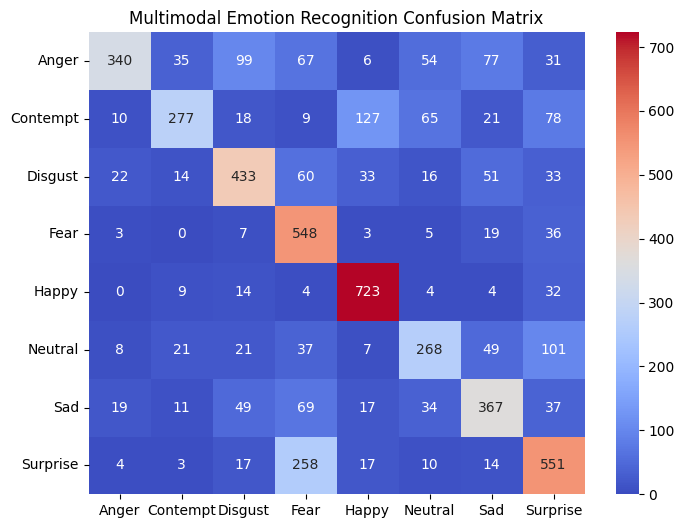

In [62]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=CLASSES, yticklabels=CLASSES)
plt.title("Multimodal Emotion Recognition Confusion Matrix")
plt.show()


              precision    recall  f1-score   support

       Anger       0.67      0.82      0.74       603
    Contempt       0.75      0.72      0.74       417
     Disgust       0.71      0.68      0.69       534
        Fear       0.79      0.69      0.73       582
       Happy       0.57      0.37      0.45        94
     Neutral       0.44      0.42      0.43       206
         Sad       0.68      0.70      0.69       462
    Surprise       0.75      0.76      0.76       648

    accuracy                           0.70      3546
   macro avg       0.67      0.65      0.65      3546
weighted avg       0.71      0.70      0.70      3546



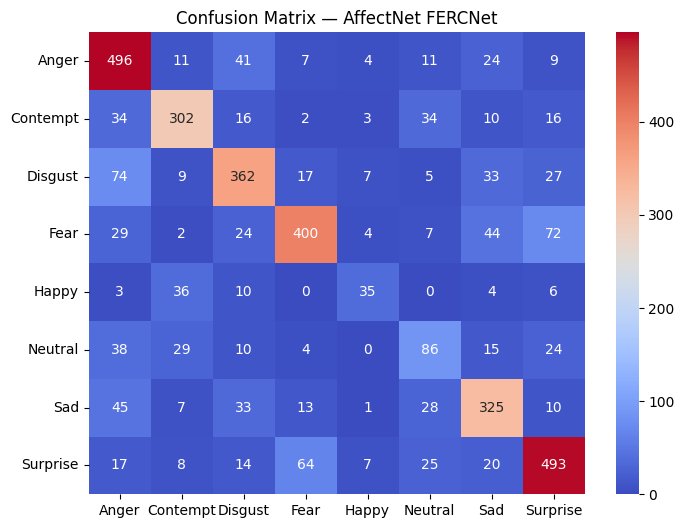

In [43]:
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in val_dl:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)
        y_true += labels.cpu().tolist()
        y_pred += preds.cpu().tolist()

print(classification_report(y_true, y_pred, target_names=CLASSES))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=CLASSES, yticklabels=CLASSES)
plt.title("Confusion Matrix — AffectNet FERCNet")
plt.show()
